# HW01: Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline 

## 1. Corner Detection

Found 10 calibration images.


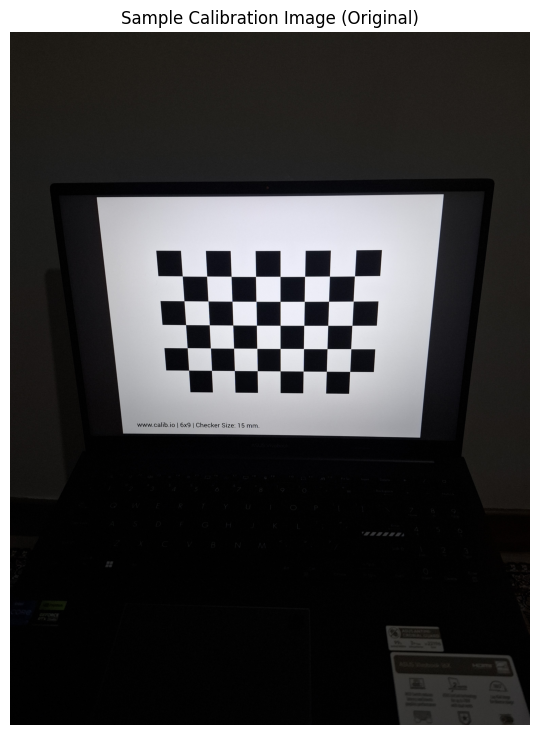

Image dimensions: 3060 x 4080 pixels


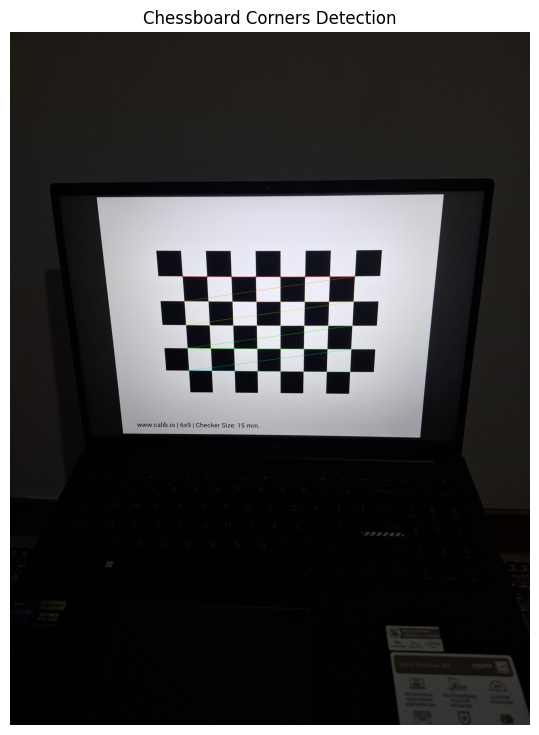

Successfully detected corners in 10 out of 10 images.

 Summary of Corner Detection Results:
- Pattern Size: (8, 5)
- Square Size: 0.021 m
- Number of Successful Detections: 10 out of 10 images. (100.00%)


In [2]:
images_path = './calibration_images/*.jpg'  
images = sorted(glob.glob(images_path))
print(f"Found {len(images)} calibration images.")

# Load and display the first image
if images:
    sample_image = cv2.imread(images[7])
    sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 9))
    plt.imshow(sample_image_rgb)
    plt.title('Sample Calibration Image (Original)')
    plt.axis('off')
    plt.show()
else:
    print("Error! No calibration images found.")

# Print image dimensions
if 'sample_image' in locals():
    print(f"Image dimensions: {sample_image.shape[1]} x {sample_image.shape[0]} pixels")

# Define chessboard size and square size (in meters)
pattern_size = (8,5)  
square_size = 0.021

objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2) * square_size
objpoints = []  
image_points = [] 

for fname in images:
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)  # Find the chessboard corners

    # if found, add object points and image points
    if ret:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        objpoints.append(objp)
        image_points.append(corners)

        # Draw and display the corners on a sample image
        if fname == images[7]:  
            image_corners = cv2.drawChessboardCorners(image.copy(), pattern_size, corners, ret)
            plt.figure(figsize=(14, 9))
            plt.imshow(cv2.cvtColor(image_corners, cv2.COLOR_BGR2RGB))
            plt.title('Chessboard Corners Detection')
            plt.axis('off')
            plt.show()
print(f"Successfully detected corners in {len(objpoints)} out of {len(images)} images.")

# Summary of Corner Detection Results
successful_detections = len(objpoints)
total_images = len(images)
success_percentage = (successful_detections / total_images) * 100

print("\n Summary of Corner Detection Results:")
print(f"- Pattern Size: {pattern_size}")
print(f"- Square Size: {square_size} m")
print(f"- Number of Successful Detections: {successful_detections} out of {len(images)} images. ({success_percentage:.2f}%)")

## 2. Calibration

In [3]:
h, w = sample_image.shape[:2]
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, image_points, (w, h), None, None)

# Print calibration results
print("Camera matrix K:")
print(K)
print("\nDistortion coefficients [k1, k2, p1, p2, k3]:")
print(dist)

# Compute and display mean reprojection error
total_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
    error = cv2.norm(image_points[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    total_error += error
mean_error = total_error / len(objpoints)
print("\nMean reprojection error:", mean_error)

Camera matrix K:
[[2.93136305e+03 0.00000000e+00 1.55154260e+03]
 [0.00000000e+00 2.92201288e+03 2.08731650e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients [k1, k2, p1, p2, k3]:
[[ 2.05480589e-01 -5.55604718e-01  2.30435228e-03 -1.98641481e-04
  -2.44732689e-01]]

Mean reprojection error: 0.07010120341222845


## 3. Undistortion

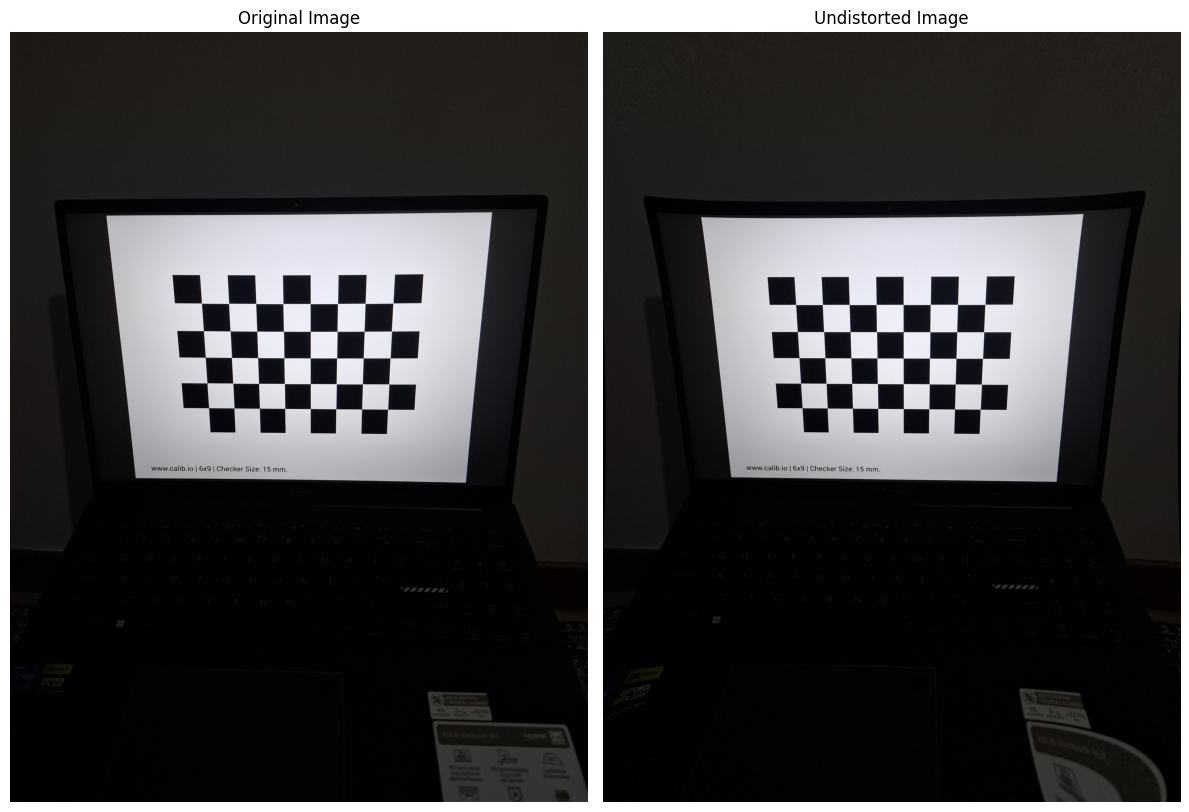

Undistortion Analysis:
1. In the undistorted image, the changes compared to the original are very subtle, but the top edge of the laptop appears slightly straighter and is shifted slightly upward.
2. This small difference results from correcting a minor amount of lens distortion and remapping the image based on the estimated calibration parameters.
3. As a result, the undistorted image has a more geometrically accurate appearance, even if the improvement is visually subtle.


In [4]:
sample_image = cv2.imread(images[7])
h, w = sample_image.shape[:2]

# Undistort the image
dst = cv2.undistort(sample_image, K, dist, None, K)

# Display the original and undistorted images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image')
ax2.axis('off')

plt.tight_layout()
plt.show()  

# Analyze the results
print("Undistortion Analysis:")
print("1. In the undistorted image, the changes compared to the original are very subtle, but the top edge of the laptop appears slightly straighter and is shifted slightly upward.")
print("2. This small difference results from correcting a minor amount of lens distortion and remapping the image based on the estimated calibration parameters.")
print("3. As a result, the undistorted image has a more geometrically accurate appearance, even if the improvement is visually subtle.")

## 4. Reprojection Check

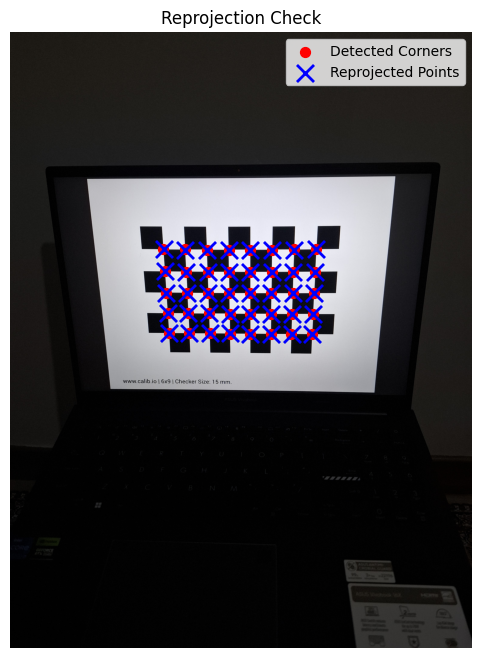


Reprojection Analysis:
The reprojected points (blue X) align almost perfectly with the detected corners (red circles), confirming the accuracy of the estimated intrinsic and extrinsic parameters.
The small residual error is likely due to noise from image acquisition, such as minor lens imperfections, motion blur, or inaccuracies in the physical square size.


In [6]:
# Select extrinsics for the first image
R_vec = rvecs[7]
T_vec = tvecs[7]
detected_points = image_points[7]
world_points = objpoints[7] 

reprojected_points, _ = cv2.projectPoints(world_points, R_vec, T_vec, K, dist)
reprojected_points = reprojected_points.reshape(-1, 2)
detected_points = detected_points.reshape(-1, 2)

# display Overlay Figure
plt.figure(figsize=(14, 8))
image_for_overlay = cv2.imread(images[7])
plt.imshow(cv2.cvtColor(image_for_overlay, cv2.COLOR_BGR2RGB))
plt.title('Reprojection Check')
plt.axis('off')
plt.scatter(detected_points[:, 0], detected_points[:, 1], s=50, c='red', marker='o', label='Detected Corners')
plt.scatter(reprojected_points[:, 0], reprojected_points[:, 1], s=150, c='blue', marker='x', label='Reprojected Points', linewidths=2)
plt.legend()
plt.show()

# Final Analysis
print("\nReprojection Analysis:")
print("The reprojected points (blue X) align almost perfectly with the detected corners (red circles), confirming the accuracy of the estimated intrinsic and extrinsic parameters.")
print("The small residual error is likely due to noise from image acquisition, such as minor lens imperfections, motion blur, or inaccuracies in the physical square size.")